In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
test_transform =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_dir = "/kaggle/input/brain-tumor/4 classes"
dataset = ImageFolder(root=data_dir, transform=train_transform)

In [7]:
# Split dataset (70-15-15 split)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
val_dataset.dataset.tranform = test_transform
test_dataset.dataset.transform = test_transform

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [10]:
# Define CNN Model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [11]:
# Initialize Model, Loss Function, and Optimizer
model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [13]:
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/20], Train Loss: 1.5348, Train Acc: 46.10%, Val Loss: 0.9660, Val Acc: 64.44%
Epoch [2/20], Train Loss: 0.8459, Train Acc: 64.79%, Val Loss: 0.7151, Val Acc: 69.40%
Epoch [3/20], Train Loss: 0.5933, Train Acc: 77.30%, Val Loss: 0.6592, Val Acc: 71.12%
Epoch [4/20], Train Loss: 0.3945, Train Acc: 85.23%, Val Loss: 0.4444, Val Acc: 84.27%
Epoch [5/20], Train Loss: 0.2568, Train Acc: 90.96%, Val Loss: 0.5899, Val Acc: 81.03%
Epoch [6/20], Train Loss: 0.1764, Train Acc: 93.91%, Val Loss: 0.3671, Val Acc: 88.15%
Epoch [7/20], Train Loss: 0.1032, Train Acc: 96.54%, Val Loss: 0.4238, Val Acc: 85.78%
Epoch [8/20], Train Loss: 0.0927, Train Acc: 97.23%, Val Loss: 0.3436, Val Acc: 88.79%
Epoch [9/20], Train Loss: 0.0722, Train Acc: 97.69%, Val Loss: 0.4239, Val Acc: 87.93%
Epoch [10/20], Train Loss: 0.0400, Train Acc: 98.75%, Val Loss: 0.4331, Val Acc: 89.87%
Epoch [11/20], Train Loss: 0.0373, Train Acc: 98.80%, Val Loss: 0.4220, Val Acc: 88.58%
Epoch [12/20], Train Loss: 0.0302, Train 

In [14]:
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 86.88%


In [15]:
# Save the Model
# torch.save(model.state_dict(), "brain_tumor.pth")

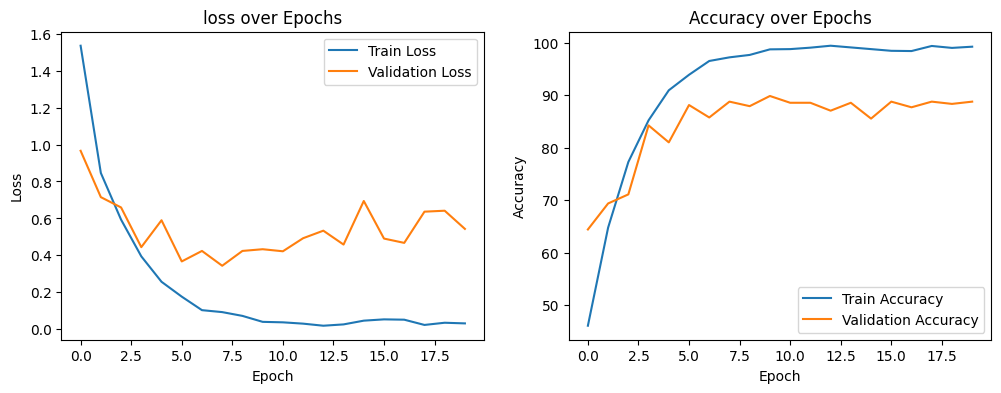

In [16]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()